# Lo Barnechea Temperature Prediction
- Using LSTM model with TFLite EI_SDK
- Predicting temperature, 1 hour in the future
- By Marcelo Rovai @ March, 2024

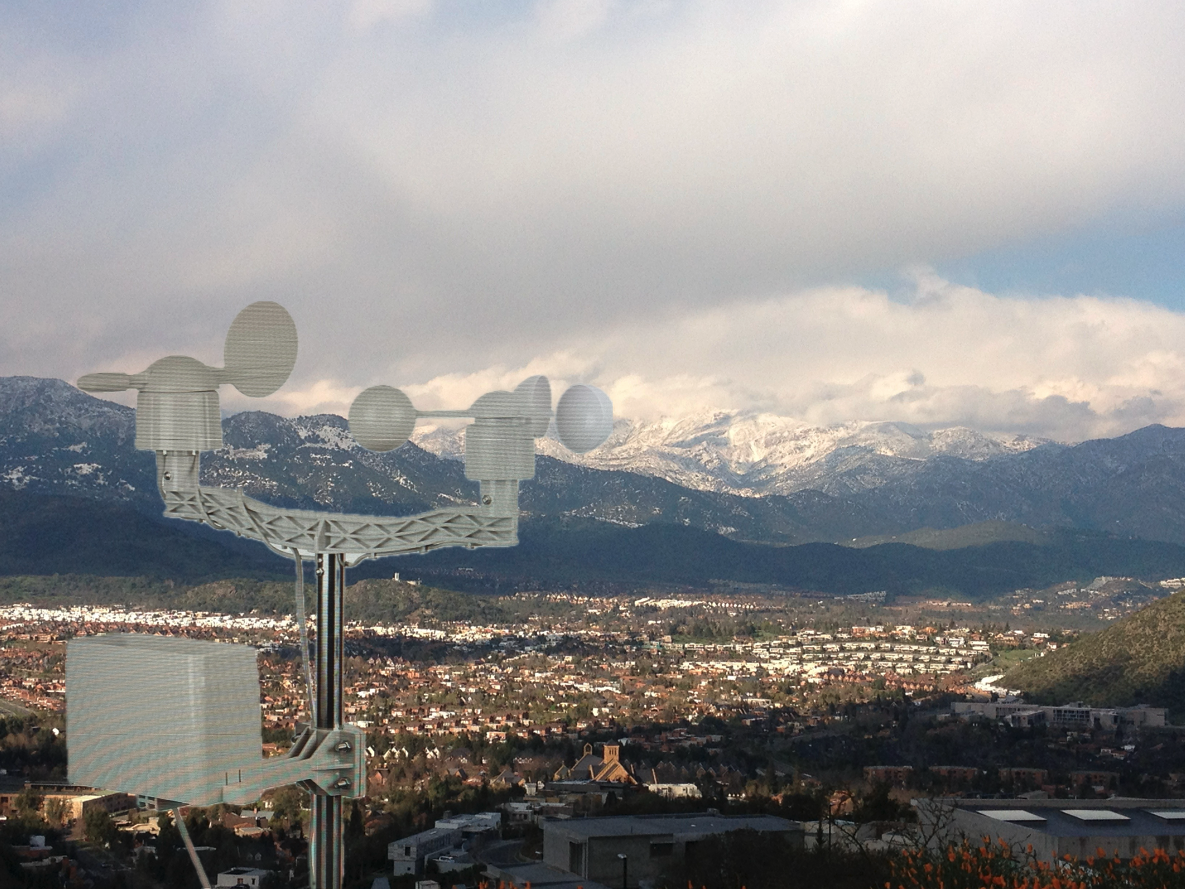

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## Load the dataset

In [3]:
df = pd.read_csv('weather_data_lo_barnechea_hourly.csv')
df.shape

(82714, 9)

In [4]:
df.head()

,date_time,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
0,2021-12-01 00:00:00,13,50,1015,0.0,1.0,3.0,225.0,Clear
1,2021-12-01 01:00:00,12,51,1015,0.0,1.0,3.0,220.0,Clear
2,2021-12-01 02:00:00,12,52,1015,0.0,1.0,2.0,216.0,Clear
3,2021-12-01 03:00:00,12,53,1014,0.0,1.0,2.0,211.0,Clear
4,2021-12-01 04:00:00,11,52,1014,0.0,1.0,2.0,224.0,Clear


In [5]:
# Sort the DataFrame by date_time
df.sort_values(by='date_time', inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df

,date_time,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
0,2010-01-01 00:00:00,11,73,1018,0.0,1.0,13.0,62.0,Clear
1,2010-01-01 01:00:00,11,73,1018,0.0,1.0,9.0,66.0,Clear
2,2010-01-01 02:00:00,11,73,1018,0.0,1.0,8.0,69.0,Clear
3,2010-01-01 03:00:00,12,73,1018,0.0,1.0,8.0,72.0,Clear
4,2010-01-01 04:00:00,13,68,1018,0.0,1.0,7.0,55.0,Clear
...,...,...,...,...,...,...,...,...,...
82709,2024-03-25 19:00:00,21,37,1013,0.0,1.0,10.0,204.0,Clear
82710,2024-03-25 20:00:00,19,42,1014,0.0,1.0,8.0,201.0,Clear
82711,2024-03-25 21:00:00,18,44,1014,0.0,1.0,7.0,202.0,Clear
82712,2024-03-25 22:00:00,17,46,1014,0.0,1.0,5.0,197.0,Clear


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82714 entries, 0 to 82713
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_time      82714 non-null  object 
 1   tempC          82714 non-null  int64  
 2   humidity       82714 non-null  int64  
 3   pressure       82714 non-null  int64  
 4   precipMM       82714 non-null  float64
 5   uvIndex        82713 non-null  float64
 6   windspeedKmph  82713 non-null  float64
 7   winddirDegree  82713 non-null  float64
 8   weatherDesc    82713 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 5.7+ MB


In [8]:
# Verify if there is any NaN
df.isna().sum()

date_time        0
tempC            0
humidity         0
pressure         0
precipMM         0
uvIndex          1
windspeedKmph    1
winddirDegree    1
weatherDesc      1
dtype: int64

In [9]:
df[df.isna().any(axis=1)]

,date_time,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
9105,2011-08-12 09:00:00,13,59,1017,0.0,NaN,NaN,NaN,NaN


In [10]:
# Selecting relevant columns
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']
data_selected = df[numeric_cols]
data_selected.shape

(82714, 7)

In [11]:
data_selected = data_selected.fillna(data_selected.mean())

In [12]:
data_selected.isna().sum()

tempC            0
humidity         0
pressure         0
precipMM         0
uvIndex          0
windspeedKmph    0
winddirDegree    0
dtype: int64

In [13]:
data_selected.head()

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree
0,11,73,1018,0.0,1.0,13.0,62.0
1,11,73,1018,0.0,1.0,9.0,66.0
2,11,73,1018,0.0,1.0,8.0,69.0
3,12,73,1018,0.0,1.0,8.0,72.0
4,13,68,1018,0.0,1.0,7.0,55.0


In [14]:
# For display only
five_weeks_data = data_selected[:840]
five_weeks_data

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree
0,11,73,1018,0.0,1.0,13.0,62.0
1,11,73,1018,0.0,1.0,9.0,66.0
2,11,73,1018,0.0,1.0,8.0,69.0
3,12,73,1018,0.0,1.0,8.0,72.0
4,13,68,1018,0.0,1.0,7.0,55.0
...,...,...,...,...,...,...,...
835,20,34,1018,0.0,1.0,9.0,149.0
836,18,38,1019,0.0,1.0,15.0,114.0
837,17,42,1020,0.0,1.0,13.0,79.0
838,16,42,1019,0.0,1.0,10.0,75.0


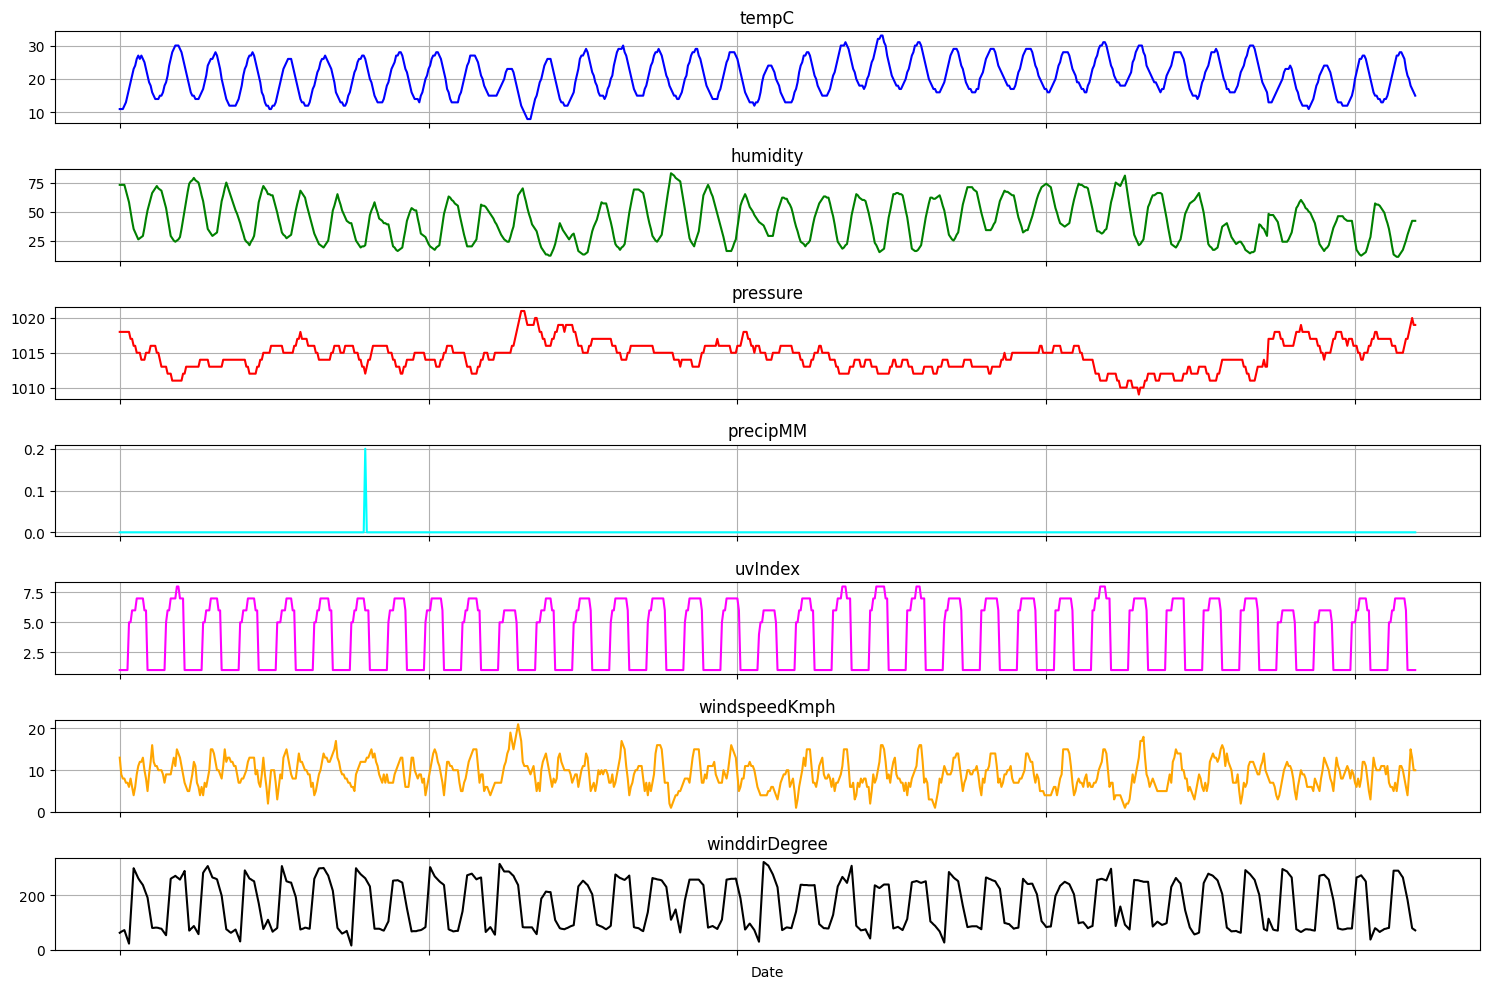

In [15]:
# Define colors for each feature for visibility
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'black']
n_features = 7
plt.figure(figsize=(15, 10))

# Plot each feature with specified color and share the x-axis
for i, (feature, color) in enumerate(zip(five_weeks_data.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)  # Share the x-axis
    five_weeks_data[feature].plot(ax=ax, color=color)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.grid(True)

    # Only show the x-axis label on the last subplot
    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

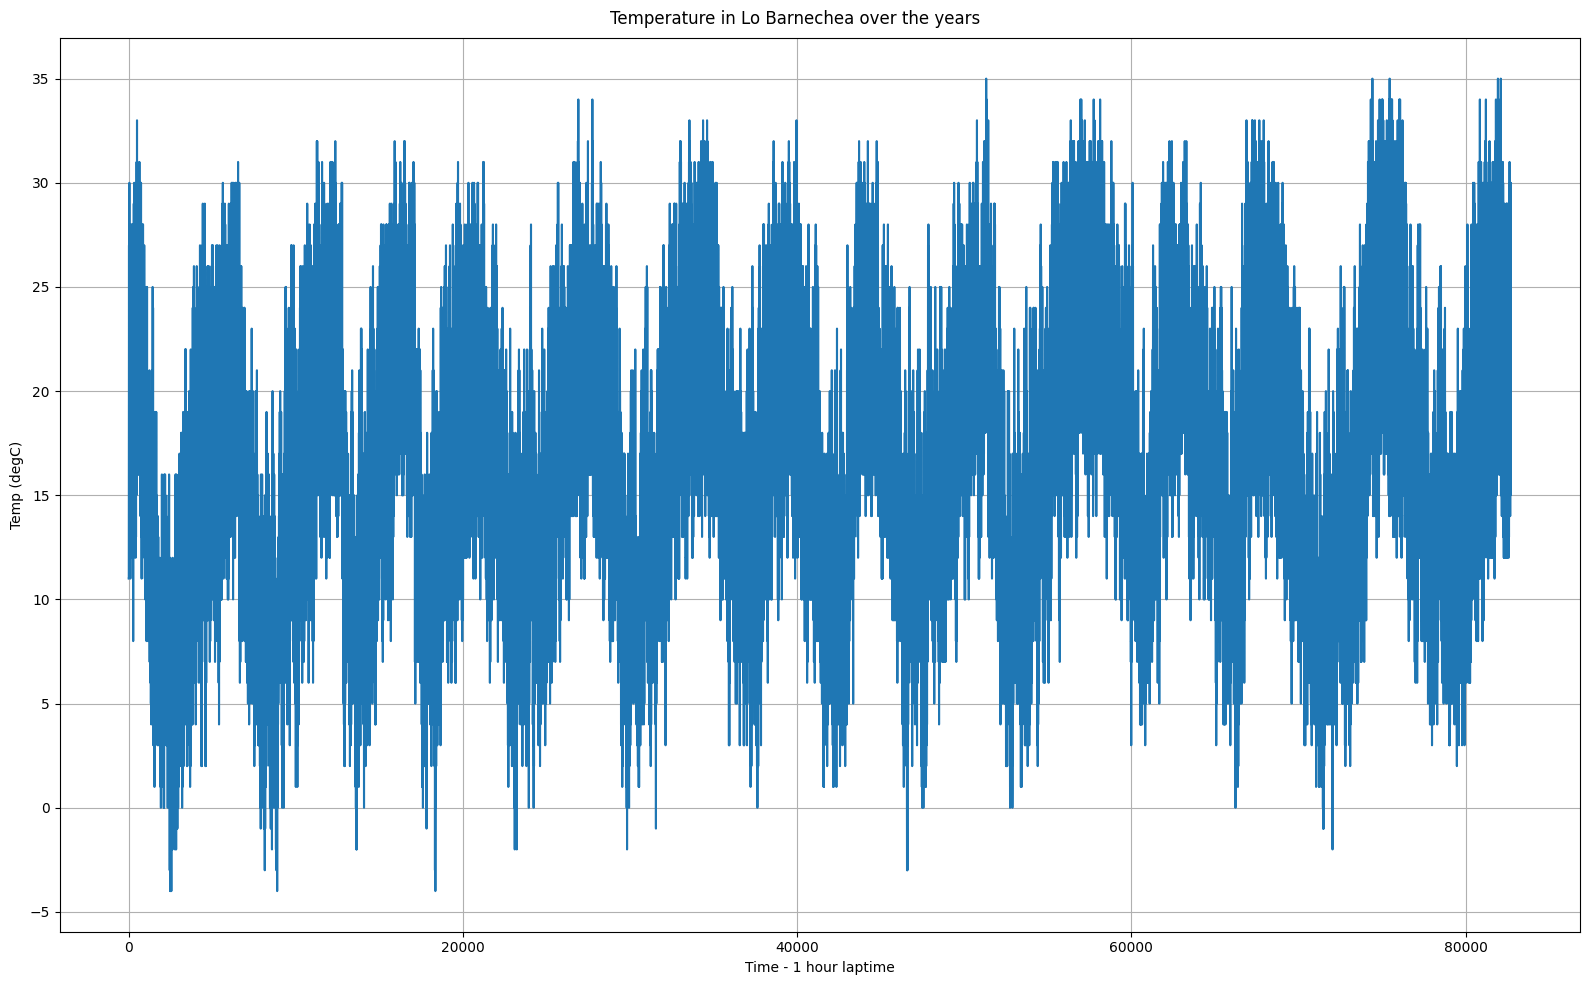

In [16]:
fig, ax1 = plt.subplots(figsize=(16, 10))

ax1.set_xlabel('Time - 1 hour laptime')
ax1.set_ylabel('Temp (degC)')
ax1.plot(data_selected['tempC'], linestyle='-')
ax1.tick_params(axis='y')

# Optional: Add a title and adjust layout
plt.suptitle('Temperature in Lo Barnechea over the years')
plt.grid()
fig.tight_layout()  # adjust subplot parameters to give specified padding

plt.show()

## Splitting the dataset into training, validation, and testing sets

In [17]:
SPLIT = 0.8

In [18]:
train_size = int(len(data_selected) * SPLIT)
val_size = int(len(data_selected) * (1-SPLIT)//2)
test_size = len(data_selected) - train_size - val_size

data_train = data_selected[:train_size]
data_val = data_selected[train_size:train_size + val_size]
data_test = data_selected[-test_size:]

data_train.shape, data_val.shape, data_test.shape

((66171, 7), (8271, 7), (8272, 7))

In [19]:
train_size, val_size, test_size

(66171, 8271, 8272)

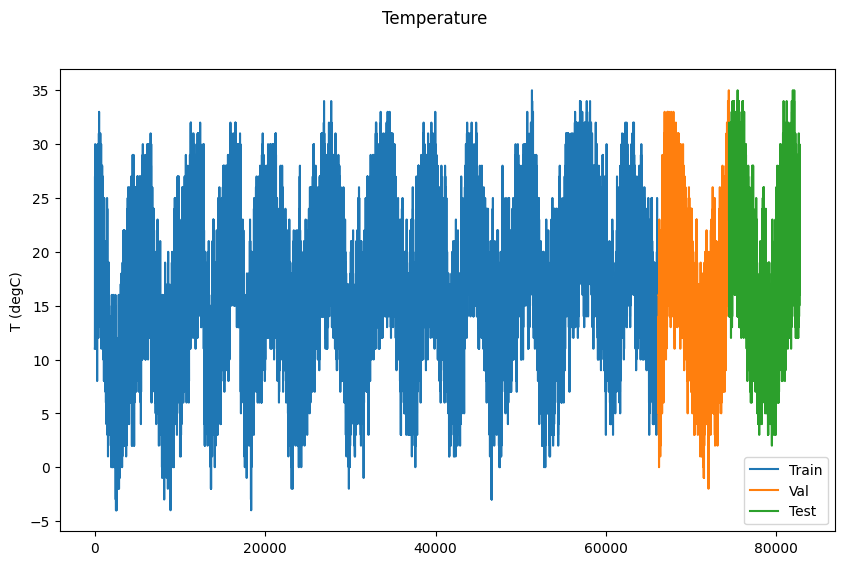

In [20]:
plt.figure(figsize=(10, 6))
data_train['tempC'].plot(legend=True)
data_val['tempC'].plot(legend=True)
data_test['tempC'].plot(legend=True)
plt.legend(['Train', 'Val', 'Test']);
plt.suptitle('Temperature')
plt.ylabel('T (degC)');

## Normalize the data

NOTE:
- The fit method should only be called on the training data, and then the transform method is used on the training, validation and test data.
- Never fit the scaler on the test data or any data used for predictions, as it can introduce future information into the model (a form of data leakage), resulting in over-optimistic performance estimates.
- Save the scaler object along with the model, so we can use the model for future predictions, ensuring we can apply the same scaling to new data.

In [21]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_normalized = scaler.fit_transform(data_train)
data_val_normalized = scaler.transform(data_val)
data_test_normalized = scaler.transform(data_test)

### Save the scaler parameters to a Text file

In [22]:
# Save the scaler parameters to a text file
with open('scaler_params.txt', 'w') as file:
    file.write('scale:' + ','.join(map(str, scaler.scale_)) + '\n')
    file.write('min:' + ','.join(map(str, scaler.min_)) + '\n')
    file.write('data_min:' + ','.join(map(str, scaler.data_min_)) + '\n')
    file.write('data_max:' + ','.join(map(str, scaler.data_max_)) + '\n')
    file.write('data_range:' + ','.join(map(str, scaler.data_range_)) + '\n')

In [23]:
print(f'Train: {data_train_normalized.min()}, {data_train_normalized.max()}')
print(f'Test:  {data_test_normalized.min()}, {data_test_normalized.max()}')
print(f'Val:   {data_val_normalized.min()}, {data_val_normalized.max()}')

Train: 0.0, 1.0
Test:  0.0, 1.0434782608695652
Val:   0.0, 1.0


## Create Features
- Prediction will be Temperature

In [24]:
def create_sequences(input_data, n_steps, fut_hours, out_feat_index):
    X, y = [], []
    for i in range(len(input_data) - n_steps - fut_hours):
        # Define the end of the input sequence
        end_ix = i + n_steps
        # Define the end of the output sequence
        out_end_ix = end_ix + fut_hours
        # Ensure we have enough data for this instance
        if out_end_ix > len(input_data):
            break
        # Retrieve input and output
        seq_x, seq_y = input_data[i:end_ix, :], input_data[out_end_ix - 1, out_feat_index]  # i.e. 0 is the index for 'tempC'
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [25]:
# Creating sequences (using 168 timesteps, which is 1 weekm 7x24)
output_feature = 'tempC'
out_feat_index = numeric_cols.index(output_feature)
fut_hours = 1
n_steps = 168
n_inputs = len(data_selected.columns)

In [ ]:
X_train, y_train = create_sequences(data_train_normalized, n_steps, fut_hours, out_feat_index)
X_val, y_val = create_sequences(data_val_normalized, n_steps, fut_hours, out_feat_index)
X_test, y_test = create_sequences(data_test_normalized, n_steps, fut_hours, out_feat_index)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(99040, 168, 7) (99040,)
(12234, 168, 7) (12234,)
(12232, 168, 7) (12232,)


## Design Model

In [ ]:
# Building the LSTM model
model = Sequential([
    LSTM(128,
         input_shape=(n_steps, X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69761 (272.50 KB)
Trainable params: 69761 (272.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training Model

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True)

In [ ]:
# Define your batch size and EPOCHS
BATCH = 32
EPOCHS = 20

In [ ]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    batch_size=BATCH,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
3095/3095 [==============================] - 612s 197ms/step - loss: 0.0011 - val_loss: 4.5169e-04
Epoch 2/20
3095/3095 [==============================] - 630s 203ms/step - loss: 2.7352e-04 - val_loss: 3.0659e-04
Epoch 3/20
3095/3095 [==============================] - 624s 202ms/step - loss: 2.5215e-04 - val_loss: 2.9222e-04
Epoch 4/20
3095/3095 [==============================] - 616s 199ms/step - loss: 2.3728e-04 - val_loss: 2.8319e-04
Epoch 5/20
3095/3095 [==============================] - 615s 199ms/step - loss: 2.2699e-04 - val_loss: 2.8486e-04
Epoch 6/20
3095/3095 [==============================] - 609s 197ms/step - loss: 2.1675e-04 - val_loss: 3.1003e-04
Epoch 7/20
3095/3095 [==============================] - 608s 196ms/step - loss: 2.1247e-04 - val_loss: 2.7819e-04
Epoch 8/20
3095/3095 [==============================] - 619s 200ms/step - loss: 2.0826e-04 - val_loss: 2.7319e-04
Epoch 9/20
3095/3095 [==============================] - 609s 197ms/step - loss: 2.0520e-04 -

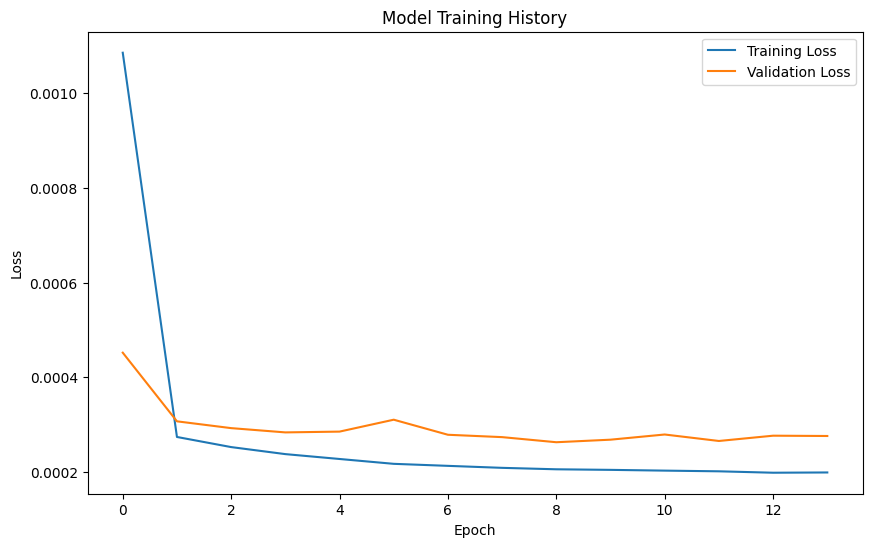

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
from math import sqrt
err = model.evaluate(X_test, y_test)
print(f'  RMSE test:\t {sqrt(err):.3f}')

383/383 [==============================] - 32s 83ms/step - loss: 4.4916e-04
  RMSE test:	 0.021


In [ ]:
prediccion = model.predict(X_test)

383/383 [==============================] - 35s 91ms/step


In [ ]:
prediccion

array([[0.47076452],
       [0.4737175 ],
       [0.5389894 ],
       ...,
       [0.548707  ],
       [0.52599514],
       [0.5087284 ]], dtype=float32)

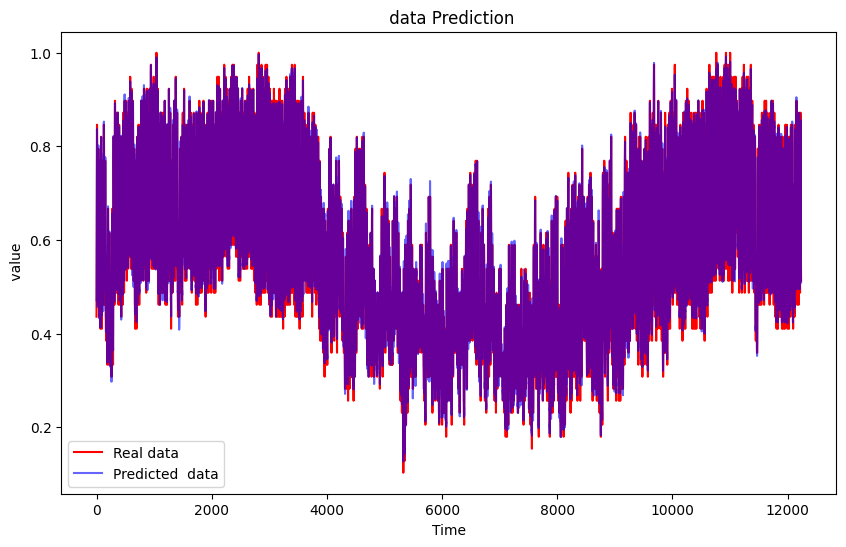

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(prediccion, color = 'blue', label = 'Predicted  data', alpha = 0.6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()

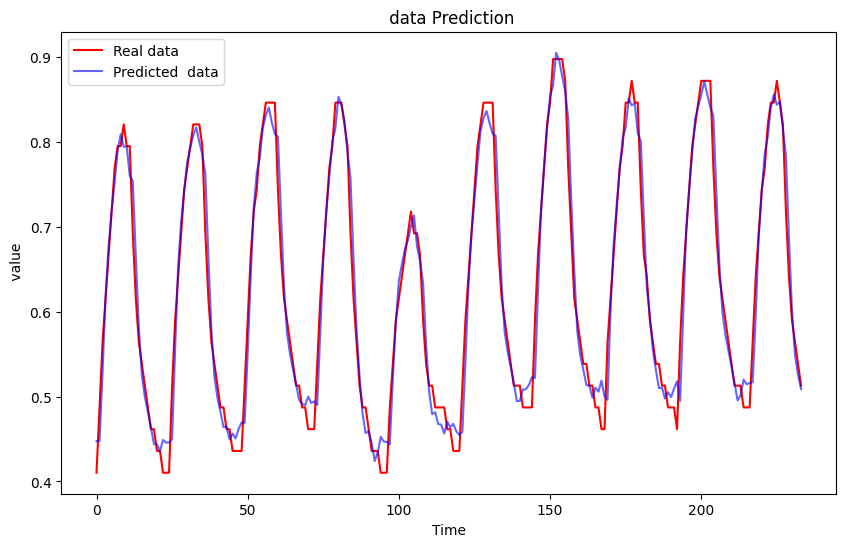

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[12000:], color = 'red', label = 'Real data')
plt.plot(prediccion[12000:], color = 'blue', label = 'Predicted  data', alpha = 0.6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()

## Create TFLite LSTM Model - Float32

- EI does support LSTM since tflite micro update last year, but it comes with a few limitations, most importantly, the converted tflite model should have **UnidirectionalLSTM** operator
- Float32 is supported and tested, while quantized model does not seem to work (even with full tflite)

In [ ]:
run_model = tf.function(lambda x: model(x))

BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = n_inputs
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

# Save the converted model to file
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)


In [ ]:
# Initialize the TFLite interpreter
interp = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
interp.allocate_tensors()

# Get input/output layer information
i_details = interp.get_input_details()[0]
o_details = interp.get_output_details()[0]

In [ ]:
i_details

{'name': 'serving_default_x:0',
 'index': 0,
 'shape': array([  1, 168,   7], dtype=int32),
 'shape_signature': array([  1, 168,   7], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [ ]:
o_details

{'name': 'StatefulPartitionedCall:0',
 'index': 22,
 'shape': array([1, 1], dtype=int32),
 'shape_signature': array([1, 1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

## Deploy LSTM Float32 Model (Unidirecional operator)

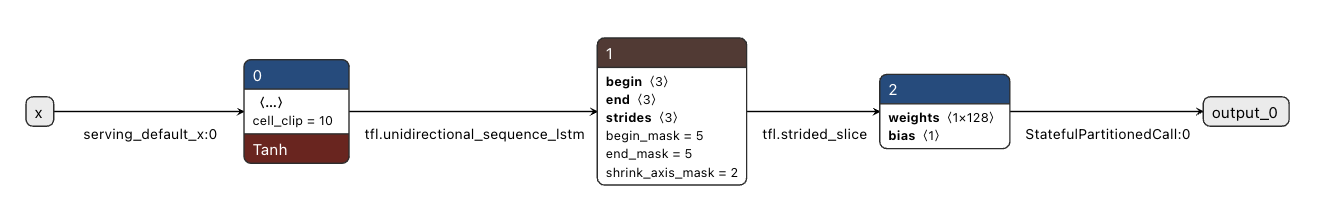

### Install the Python SDK library:

In [ ]:
!python -m pip install edgeimpulse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.4
    Uninstalling pydantic-2.6.4:
      Successfully uninstalled pydantic-2.6.4


In [ ]:
ei.API_KEY = "Your Key" # Change to your key

In [ ]:
# Estimate the RAM, ROM, and inference time for our model on the target hardware family
try:
    profile = ei.model.profile(model=tflite_model,
                               device='espressif-esp32')
    print(profile.summary())
except Exception as e:
    print(f"Could not profile: {e}")

Target results for float32:
{
    "device": "espressif-esp32",
    "tfliteFileSizeBytes": 283024,
    "isSupportedOnMcu": true,
    "memory": {
        "tflite": {
            "ram": 116516,
            "rom": 324136,
            "arenaSize": 116300
        },
        "eon": {
            "ram": 96952,
            "rom": 304936
        }
    },
    "timePerInferenceMs": 31258
}


Performance on device types:
{
    "variant": "float32",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 355370,
        "memory": {
            "tflite": {
                "ram": 116478,
                "rom": 319512
            },
            "eon": {
                "ram": 96920,
                "rom": 304824
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInferenceMs": 2810,
        "me

In [ ]:
download_dir = "./"
deploy_filename = "lstm_float32_model.zip"

In [ ]:
# Create an Arduino library with trained model
deploy_bytes = None
try:
    deploy_bytes = ei.model.deploy(tflite_model,
                                   model_output_type=ei.model.output_type.Regression(),
                                   deploy_target='arduino')
except Exception as e:
    print(f"Could not deploy: {e}")

# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())

## Generate test datapoint for inference

In [ ]:
y_test[0]

0.3589743589743589

In [ ]:
X_test[0].shape

(168, 7)

In [ ]:
reshaped_test = X_test[0].reshape(-1)
reshaped_test.shape

(1176,)

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
reshaped_test

array([0.38461538, 0.48979592, 0.4516129 , 0.        , 0.        ,
       0.04347826, 0.47777778, 0.38461538, 0.48979592, 0.4516129 ,
       0.        , 0.        , 0.        , 0.41666667, 0.41025641,
       0.5       , 0.4516129 , 0.        , 0.375     , 0.        ,
       0.35555556, 0.46153846, 0.43877551, 0.4516129 , 0.        ,
       0.375     , 0.04347826, 0.46666667, 0.51282051, 0.37755102,
       0.4516129 , 0.        , 0.5       , 0.13043478, 0.575     ,
       0.58974359, 0.31632653, 0.4516129 , 0.        , 0.5       ,
       0.17391304, 0.68611111, 0.61538462, 0.28571429, 0.4516129 ,
       0.        , 0.625     , 0.2173913 , 0.65277778, 0.66666667,
       0.26530612, 0.4516129 , 0.        , 0.625     , 0.30434783,
       0.61666667, 0.71794872, 0.24489796, 0.41935484, 0.        ,
       0.625     , 0.34782609, 0.58333333, 0.74358974, 0.2244898 ,
       0.41935484, 0.        , 0.625     , 0.47826087, 0.57777778,
       0.76923077, 0.21428571, 0.41935484, 0.        , 0.75   

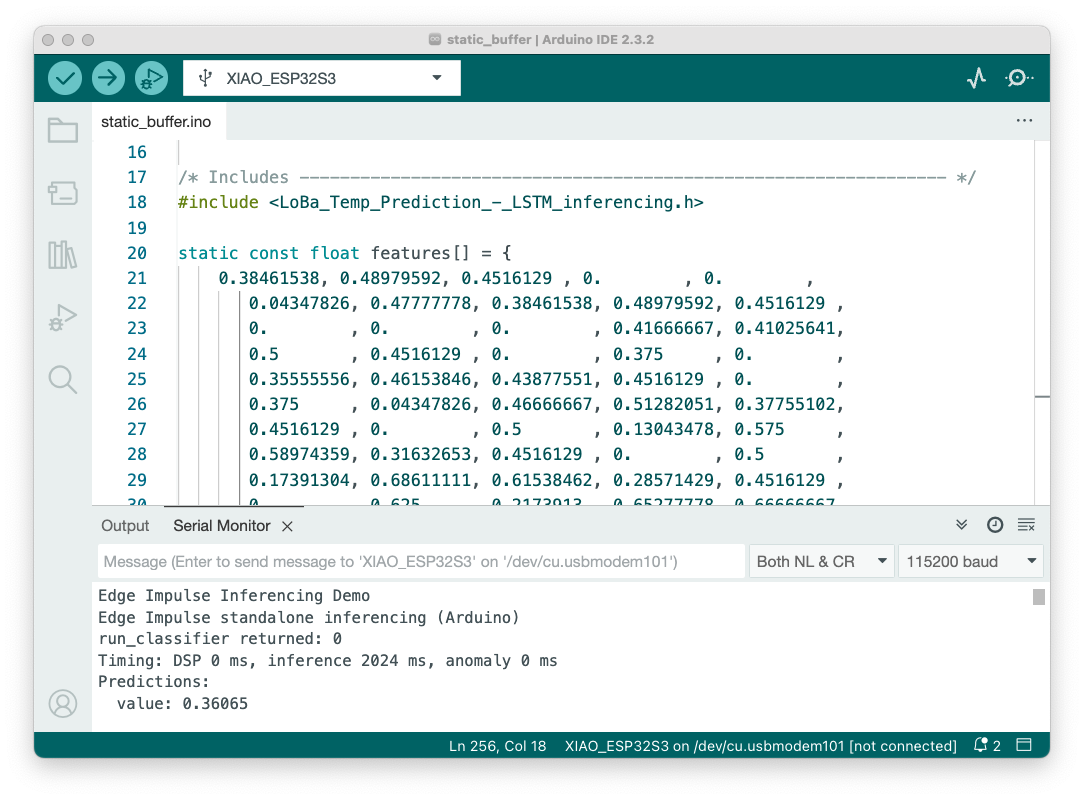

### Rescaling inference result to real temperaure

To load these parameters back into a MinMaxScaler instance:

In [ ]:
# Load the scaler parameters from the text file
loaded_scaler_params = {}
with open('scaler_params.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(':')
        loaded_scaler_params[key] = np.array([float(i) for i in value.split(',')])

# Create a new scaler instance and set its parameters
inference_scaler = MinMaxScaler()
inference_scaler.scale_ = loaded_scaler_params['scale']
inference_scaler.min_ = loaded_scaler_params['min']
inference_scaler.data_min_ = loaded_scaler_params['data_min']
inference_scaler.data_max_ = loaded_scaler_params['data_max']
inference_scaler.data_range_ = loaded_scaler_params['data_range']

In [ ]:
inference_scaler.data_min_.shape

(7,)

In [ ]:
data_min = inference_scaler.data_min_[0]
data_min

-4.0

In [ ]:
data_max = inference_scaler.data_max_[0]
data_max

35.0

In [ ]:
value = 0.36065
temp = value * (data_max - data_min) + data_min
temp

10.06535